# Transfer Learning Models
***
### Additional modeling process using pretrained models.  


Import neccesary packages and libraries 

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from helper_functions import *
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 
from keras.callbacks import EarlyStopping

### Read in Data
Read in data with ImageDataGenerator.  Created validation set from training dataset.  

In [3]:
test_directory = 'Alzheimer_s Dataset/test/'
train_directory = 'Alzheimer_s Dataset/train/'

data_genorator = ImageDataGenerator(rescale=1./255,validation_split=0.2)


data_train= data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 4098, 
        seed = 123)

data_valid = data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'validation',
        target_size=(224, 224), 
        batch_size = 1023, 
        seed = 123)

data_test= ImageDataGenerator(rescale=1./255).flow_from_directory( 
        test_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 1279, 
        seed = 123)

### Seperate lables from images

In [9]:
train_images, train_labels = next(data_train)

test_images, test_labels = next(data_test)

valid_images, valid_labels = next(data_valid)

### Import Augmented image dataset from previous notebook

Read in augmented dataset and seperate images from labels.    

In [12]:
from pickle import load

In [15]:
train_images_aug, train_labels_aug = load(open('train_aug.pickle','rb'))

In [16]:
train_images_aug.shape

(6000, 224, 224, 3)

In [17]:
train_labels_aug.shape

(6000, 4)

## AlexNet Model
Transfer learning model, best know for high accuracy in image classification. We tried with both unaltered and augmented datasets.

In [56]:
batch_size = 24
num_classes = 4
epochs = 30
np.random.seed(7)


alex_no_aug = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

alex_no_aug.summary()

alex_no_aug.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

alex_no_aug_history = alex_no_aug.fit(train_images, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = alex_no_aug.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_48 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_49 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 12, 12, 384)     

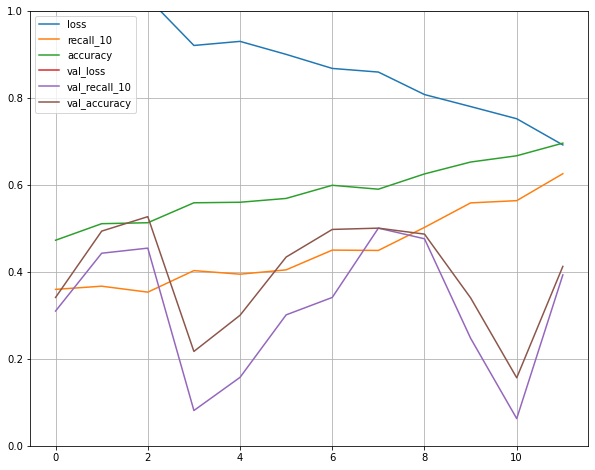

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Normalized confusion matrix
[[0.08938547 0.         0.47486034 0.43575419]
 [0.         0.         0.66666667 0.33333333]
 [0.         0.         0.878125   0.121875  ]
 [0.00446429 0.         0.72544643 0.27008929]]


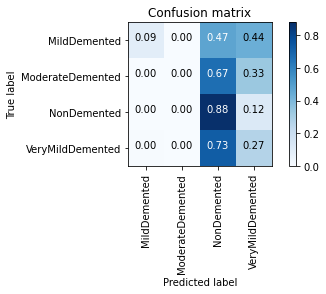

In [59]:
history_alex_noaug_df = pd.DataFrame(alex_no_aug_history.history)
history_alex_noaug_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
y_pred = alex_no_aug.predict_classes(test_images)
confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices,normalize=True)

AlexNet classified most if not all images as the NonDemented class.  This method did not preform as well as our basic cnn, most likely due to the sparse number of images in our dataset compared to the original alexnet being trained on 1.2 million images.  

### Running AlexNet With Augmented Data


In [63]:
batch_size = 24
num_classes = 4
epochs = 30
np.random.seed(7)

alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

alex.summary()

alex.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

alex_history = alex.fit(train_images_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = alex.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization_53 (Batc (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_54 (Batc (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 12, 12, 384)     

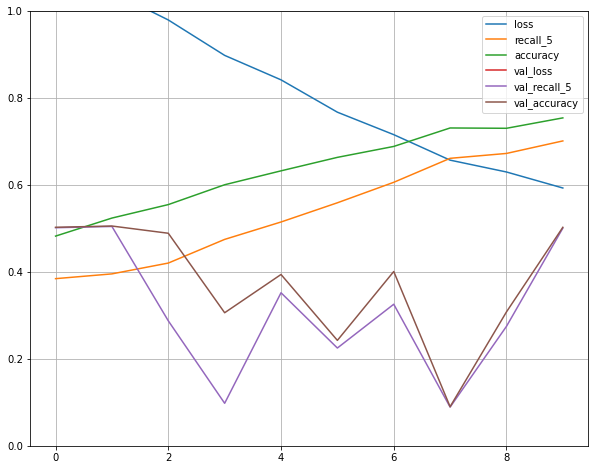

Normalized confusion matrix
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


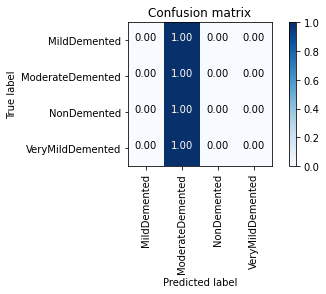

In [60]:
history_alex_df = pd.DataFrame(alex_history.history)
history_alex_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
y_pred = alex.predict_classes(test_images)
confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices,normalize=True)

Our AlexNet with augmented Imageges resulted in a 100% classification of just the NonDemented class.  

### Fronteir Research Paper CNN
We attempted to recreate a CNN from an MRI image classifying research paper [Fronteirs]('https://www.frontiersin.org/articles/10.3389/fnins.2018.00777/full#T1')
It consists of three convolutional layers with progressivly smaller kernel sizes.  After the first convolutional layer we used MaxPooling, followed by two rounds of avg pooling after the next two Convolutional layers.  We also had three dense layers, two with 1024 neurons using relu, and a final layer with softmax for classification.  We also inculded early stop penalties and bias, with a patience of 5 for val loss. 

In [48]:
batch_size = 50
num_classes = 4
epochs = 30
np.random.seed(7)

frontiers = models.Sequential()

frontiers.add(layers.Conv2D(32,(32,32),padding= 'same',activation = 'relu', input_shape=(224,224,3),use_bias=True))
frontiers.add(layers.BatchNormalization())
frontiers.add(layers.MaxPooling2D((16,16),strides=2))
frontiers.add(layers.Conv2D(32,(16,16),padding ='same',activation = 'relu',use_bias=True))
frontiers.add(layers.BatchNormalization())
frontiers.add(layers.AveragePooling2D((8,8),strides=2))
frontiers.add(layers.Conv2D(64,(8,8),padding = 'same',activation = 'relu',use_bias=True))
frontiers.add(layers.BatchNormalization())
frontiers.add(layers.AveragePooling2D((8,8)))
frontiers.add(layers.Flatten())
frontiers.add(Dense(1024,activation ='relu'))
frontiers.add(Dense(1024,activation ='relu'))
frontiers.add(Dense(4,activation = 'softmax'))

frontiers.summary()

frontiers.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=[Recall(),'accuracy'])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

frontiers_history = frontiers.fit(train_images_aug, train_labels_aug,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = [early_stop],
                    validation_data=(valid_images, valid_labels))

score = frontiers.evaluate(test_images, test_labels, verbose=0)

print('test loss:', score[0])
print('Test recall:', score[1])
print('Test Accuracy', score[2])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 224, 224, 32)      98336     
_________________________________________________________________
batch_normalization_15 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 105, 105, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 105, 105, 32)      262176    
_________________________________________________________________
batch_normalization_16 (Batc (None, 105, 105, 32)      128       
_________________________________________________________________
average_pooling2d_6 (Average (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 49, 49, 64)       

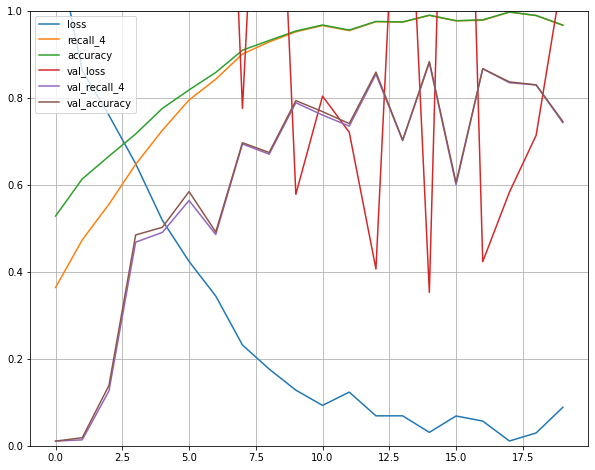

Normalized confusion matrix
[[0.34636872 0.00558659 0.30726257 0.34078212]
 [0.         0.25       0.33333333 0.41666667]
 [0.0125     0.         0.89375    0.09375   ]
 [0.04241071 0.00223214 0.48214286 0.47321429]]


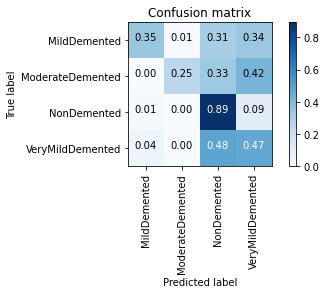

In [66]:
frontier_df = pd.DataFrame(frontiers_history.history)
frontier_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.savefig('./images/loss_curve_front.png')
plt.show()


y_pred = frontiers.predict_classes(test_images)
confusion = confusion_matrix(test_labels.argmax(axis=1),y_pred)
plot_confusion_matrix(confusion,data_test.class_indices,normalize=True)

plt.savefig('./images/confusion_matrix_front.png')

Our frontiers CNN yeilded our best accuracy and recall both about 66%.  According to the confusion matrix, there are still errors in classifying the NonDemented and very mild class.  

### Layer Classification Visualization
Observing the key features used to classify for each layer in the frontiers dataset

In [67]:
# Select a moderately demedted image that was correctly identified by the model
a= load_img('./Alzheimer_s Dataset/test/ModerateDemented/27.jpg',target_size=(224,224))
a_array = np.array([img_to_array(a)])

# have the model predict the class
frontiers.predict_classes(a_array)

array([1])

conv2d_15 (32, 32, 3, 32)
32
conv2d_16 (16, 16, 32, 32)
32
conv2d_17 (8, 8, 32, 64)
64
(1, 224, 224, 32)
(1, 105, 105, 32)
(1, 105, 105, 32)
(1, 105, 105, 32)
(1, 49, 49, 32)
(1, 49, 49, 64)
(1, 49, 49, 64)
(1, 6, 6, 64)
(1, 2304)
(1, 1024)
(1, 1024)
(1, 4)


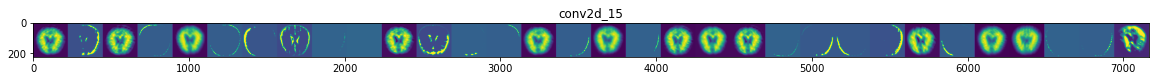

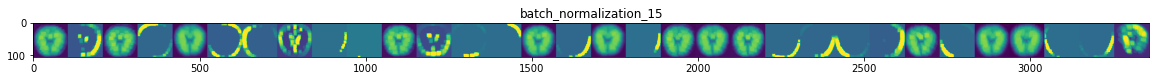

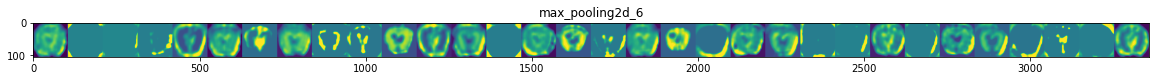

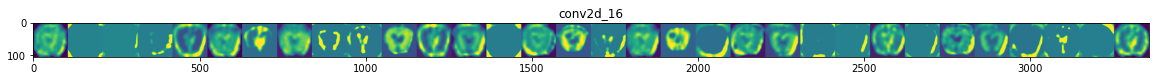

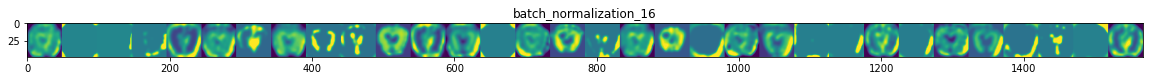

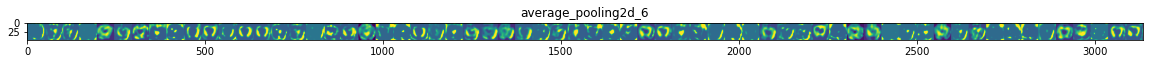

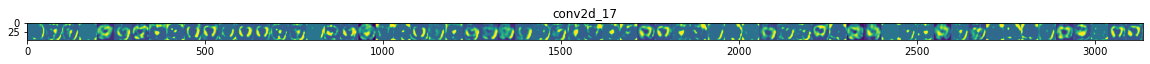

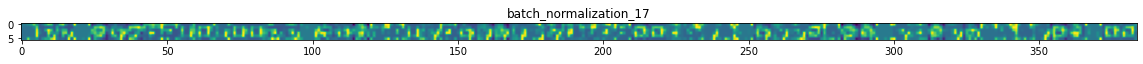

In [73]:
# get layer weights and filters from model
for layer in frontiers.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        axis_x=1

#use image above to run through model
img_path='./Alzheimer_s Dataset/test/ModerateDemented/27.jpg' 

#create visualization model to demonstrate what features Frontiers is learning 
#at each layer
successive_outputs = [layer.output for layer in frontiers.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = frontiers.input, outputs = successive_outputs)

img = load_img(img_path, target_size=(224, 224)) 

x   = img_to_array(img)                           # Numpy array with shape (224, 224, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 224, 224, 3)

# Rescale by 1/255
x /= 255.0

# Run image through visualization model
successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in frontiers.layers]

# display representations at each layer
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Isolate only the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # Tile images in matrix
    display_grid = np.zeros((size, size * n_features))
    
    #create grid
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
    plt.savefig(f'./images/features_viz_front{layer_name}.png')

Clear feature recognition along the outside of the brain images, indicating feature selection based on the atrophy of grey matter in the cerebral cortex.  


## Conclusions
 The primary goal of this study, was to create a highly accurate image classifier to act as a primary diagnosis tool.  To acheive our goal we trained several nerual networks with our image data set, and attemped to increase the recall by tuning the parameters of each model.  We found that we where unable to improve our models past a 66% recall on our test set.  We suspect that the low accuracy and recall is most likely due to the ambiguity between brain atrophy from (AD) and the actual onset of dementia symptoms. In several papers, it has been noted that the atrophy of the brain may occur at a far earlier time than the symptoms they cause. There is a likely chance that our model was classifying the images by the level of atrophy present, but these images belonged to a different symptom class due to whatever symptom the patient was labled with at the time of imaging. Another factor could be that our imaging classifier was unable to distinguish the difference between the features of dementia patients and the normal degeneration of the brain that comes along with age, and is not synonymous with dementia.  

## Next Steps
Future studies will need to address the issue of variatability in the brains structure and the indierect releationship between atrophy and the severity of dementia.  One avanue would be to find a new dataset with a different set of lables that catagorizes the severity of atrophy and not the associated symptoms.  Another step would be to address the issue of how aging healthy brains may be confused with atrophied brains.  Finally we would also like to explore several other CNN structures, and additional transfer learning models to further improve the classification accuracy and recall.  
